# Azure embeddings example

This example will cover embeddings using the Azure OpenAI service.

## Setup

First, we install the necessary dependencies and import the libraries we will be using.

In [1]:
! pip install openai
! pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import openai
import dotenv

dotenv.load_dotenv()

True

### Authentication

The Azure OpenAI service supports multiple authentication mechanisms that include API keys and Azure Active Directory token credentials.

In [3]:
use_azure_active_directory = False  # Set this flag to True if you are using Azure Active Directory

#### Authentication using API key

To set up the OpenAI SDK to use an *Azure API Key*, we need to set `api_key` to a key associated with your endpoint (you can find this key in *"Keys and Endpoints"* under *"Resource Management"* in the [Azure Portal](https://portal.azure.com)). You'll also find the endpoint for your resource here.

In [4]:

if not use_azure_active_directory:
    api_key = os.environ["AZURE_OPENAI_API_KEY"]
    endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]

    client = openai.AzureOpenAI(
        azure_endpoint=endpoint,
        api_key=api_key,
        api_version="2023-09-01-preview"
    )

#### Authentication using Azure Active Directory
Let's now see how we can authenticate via Azure Active Directory. We'll start by installing the `azure-identity` library. This library will provide the token credentials we need to authenticate and help us build a token credential provider through the `get_bearer_token_provider` helper function. It's recommended to use `get_bearer_token_provider` over providing a static token to `AzureOpenAI` because this API will automatically cache and refresh tokens for you. 

For more information on how to set up Azure Active Directory authentication with Azure OpenAI, see the [documentation](https://learn.microsoft.com/azure/ai-services/openai/how-to/managed-identity).

In [5]:
! pip install "azure-identity>=1.15.0"


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

if use_azure_active_directory:
    endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
    api_key = os.environ["AZURE_OPENAI_API_KEY"]

    client = openai.AzureOpenAI(
        azure_endpoint=endpoint,
        azure_ad_token_provider=get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"),
        api_version="2023-09-01-preview"
    )

> Note: the AzureOpenAI infers the following arguments from their corresponding environment variables if they are not provided:

- `api_key` from `AZURE_OPENAI_API_KEY`
- `azure_ad_token` from `AZURE_OPENAI_AD_TOKEN`
- `api_version` from `OPENAI_API_VERSION`
- `azure_endpoint` from `AZURE_OPENAI_ENDPOINT`


## Deployments

In this section we are going to create a deployment of a model that we can use to create embeddings.

### Deployments: Create in the Azure OpenAI Studio
Let's deploy a model to use with embeddings. Go to https://portal.azure.com, find your Azure OpenAI resource, and then navigate to the Azure OpenAI Studio. Click on the "Deployments" tab and then create a deployment for the model you want to use for embeddings. The deployment name that you give the model will be used in the code below.

In [7]:
deployment = "text-embedding-ada-002" # Fill in the deployment name from the portal here

## Embeddings

Now let's create embeddings using the client we built.

In [8]:
embeddings = client.embeddings.create(
    model=deployment,
    input="The food was delicious and the waiter..."
)
                                
print(embeddings)

PermissionDeniedError: Error code: 403 - {'error': {'code': '403', 'message': 'Public access is disabled. Please configure private endpoint.'}}

# Ejercicio 1: Generar múltiples embeddings y calcular similitud entre frases
## Objetivo: Aprender a generar embeddings para múltiples textos y calcular similitudes entre ellos.


In [12]:
# Lista de textos a procesar
texts = [
    "The weather is sunny and warm.",
    "It's a cold and rainy day.",
    "I love spending time at the beach.",
    "Reading books indoors on a rainy day is relaxing."
]

# Crear embeddings para cada texto
embeddings_list = []
for text in texts:
    response = client.embeddings.create(
    model=deployment,
    input=text
)
    embeddings_list.append(response.data[0].embedding)

# Calcular la similitud coseno entre embeddings
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_matrix = cosine_similarity(np.array(embeddings_list))

# Mostrar la matriz de similitud
print("Matriz de similitud:")
print(similarity_matrix)


# Ejercicio 2: Reducción de dimensionalidad y visualización de embeddings
## Objetivo: Visualizar la relación entre embeddings utilizando reducción de dimensionalidad (TSNE o PCA).


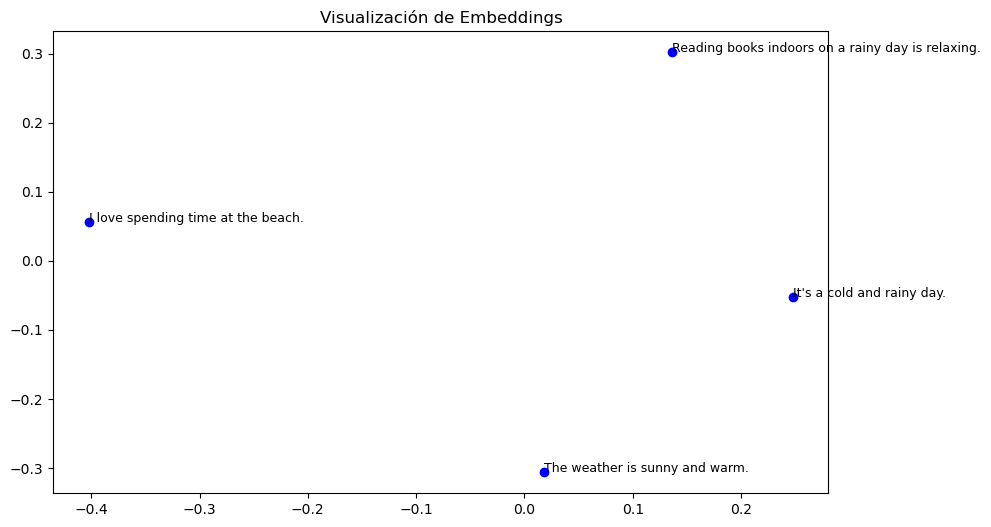

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2 dimensiones
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_list)

# Graficar los embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue')
for i, text in enumerate(texts):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], text, fontsize=9)
plt.title("Visualización de Embeddings")
plt.show()

# Ejercicio 3: Detección de temas con clustering de embeddings
## Objetivo: Agrupar textos con embeddings similares utilizando k-means.

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embeddings_list)
labels = kmeans.labels_

# Mostrar resultados de clustering
for i, text in enumerate(texts):
    print(f"Texto: {text} - Cluster: {labels[i]}")

Texto: The weather is sunny and warm. - Cluster: 0
Texto: It's a cold and rainy day. - Cluster: 0
Texto: I love spending time at the beach. - Cluster: 1
Texto: Reading books indoors on a rainy day is relaxing. - Cluster: 1


# Ejercicio 4: Construcción de un motor de búsqueda simple con embeddings
## Objetivo: Implementar un motor de búsqueda que retorne el texto más similar a una consulta usando embeddings.


In [43]:
query = "I enjoy sunny days at the beach."
response =  client.embeddings.create(
    model=deployment,
    input=text
)
query_embedding = response.data[0].embedding

# Calcular similitud entre la consulta y la lista de textos anteriores
similarities = cosine_similarity([query_embedding], embeddings_list)[0]
most_similar_index = np.argmax(similarities)

print("Consulta:", query)
print("Texto más similar:", texts[most_similar_index])

Consulta: I enjoy sunny days at the beach.
Texto más similar: I love spending time at the beach.
